# Numerical Method

### 2-D Heat Conduction

The 2D heat conduction algorithm helps us understand how heat diffuses through a two-dimensional medium over time. The governing equation is an extension of the 1D heat conduction equation and is expressed as:

\begin{align*}
\frac{\partial T}{\partial t} = \alpha (\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial z^2})
\end{align*}

where $\alpha$ is the thermal diffusivity, defined as:
\begin{align*}
\alpha = \frac{\kappa}{\rho c_p}
\end{align*}

Here $\kappa$ is the thermal conductivity, $\rho$ is the mass density, and $c_p$ is the specific heat at constant pressure.

In terms of heat capacity, the equation can also be written as:
\begin{align*}
\rho c_p \frac{\partial T}{\partial t} = \kappa \frac{\partial^2 T}{\partial x^2} + \kappa \frac{\partial^2 T}{\partial z^2}
\end{align*}

This equation describes heat diffusion in the absence of any internal heat generation. If internal heating is present, a source term $H(x, z)$ is added to the right hand side of the equation:

\begin{align*}
\rho c_p \frac{\partial T}{\partial t} = \kappa \frac{\partial^2 T}{\partial x^2} + \kappa \frac{\partial^2 T}{\partial z^2} + H(x, z)
\end{align*}

Variables:

- $T (x, z, t)$ : temperature field 
- $k$ : thermal conductivity $(W/m.K)$
- $\\rho$ : mass density $(kg/m^3)$
- $c_p$ : specific heat at constant pressure $(J/kg K)$
- $H$ : heat source term $(W/m^3)$



Similar to the 1D heat equation, solving the 2D heat equation numerically requires discretizing both space and time. For the time-dependent term on the left-hand side, we can use the forward Euler method, just as in the 1D case. For the spatial derivatives on the right-hand side, we apply the central difference method to approximate the second-order partial derivatives in both the $x$ and $z$ directions.

To complete the model, we also need to define certain assumptions, including appropriate initial conditions and boundary conditions (e.g., Dirichlet or Neumann), which are essential for a well-posed simulation.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation

### Defining the 2D Model
Before solving the 2D heat conduction equation, we first need to define the physical scenario to simulate. This includes specifying the domain size, grid resolution (spacing in the $x$ and $z$ directions), the initial temperature distribution, and the internal heat source term, if present.

In addition to the spatial setup, it's crucial to define the time step size carefully to ensure numerical stability. For explicit methods like the Forward Euler scheme, the Courant–Friedrichs–Lewy (CFL) condition provides a guideline for selecting a stable time step. Given spatial step sizes $dx$
and $dz$, and thermal diffusivity $\alpha$, the CFL condition is given by:

\begin{align*}
dt \leq \frac{1}{2 \alpha} (\frac{1}{dx^2} + \frac{1}{dz^2})^{-1}
\end{align*}

This condition ensures that the time step $dt$ is sufficiently small to prevent the numerical solution from becoming unstable. If $dt$ is too large, the simulation may produce unphysical result such as oscillations of diverging (infinite) temperatures.


In [2]:
# Let's start by creating a basic 2D heat conduction simulation setup using finite difference.
# This script will initialize a temperature grid, apply Dirichlet boundary conditions, internal heat generation,
# and perform time-stepping to simulate heat diffusion.

# --- Parameters ---
Lx, Lz = 10.0, 10.0              # domain size in x and z (meters)
Nx, Nz = 50, 50                # number of grid points
dx, dz = Lx / (Nx - 1), Lz / (Nz - 1)  # grid spacing

rho = 850                    # density (kg/m^3)
cp = 850                     # specific heat capacity (J/kg·K)
k = 700.0                    # thermal conductivity (W/m·K)
alpha = k / (rho*cp)         # thermal diffusivity (mm^2/s)
H = 1e-6                      # internal heat generation rate (W/m^3)

# --- Time settings ---
# dt less than (1/(2 alpha)) / (dx**2 + dz**2)  # time step (s)
# dt less than 10.747
cfl = (0.5*(dx**2 * dz**2)) / (alpha*(dx**2 + dz**2))
dt = 0.8 * cfl
Tmax = 10000.0                # total simulation time (s)
Nt = int(Tmax / dt)          # number of time steps


In [3]:
def apply_boundary_conditions(T):
    T[0, :] = 100.0             # top boundary
    T[-1, :] = 0.0            # bottom boundary
    T[:, 0] = 100.0             # left boundary
    T[:, -1] = 0.0            # right boundary
    return T

def solver_2d(T_init, Nx, Nz, rho, cp, H, dt, Nt):
    """
    This function solves the 2D heat conduction equation using finite difference method.

    Args:
     - T_init: Initial temperature distribution
     - Nx, Nz: Number of grid points in x and z directions
     - rho, cp: Density and specific heat capacity of the material
     - H: Heat generation rate
     - dt: Time step
     - Nt: Number of time steps
    
    Returns:
     - T_all: List of temperature snapshots
    """
    dx, dz = Lx / (Nx - 1), Lz / (Nz - 1)
    alpha = k / (rho*cp) 
    T = T_init.copy()
    T_all = []  # list to store temperature snapshots

    for t in range(Nt):
        T = apply_boundary_conditions(T)
        T_new = T.copy()

        for i in range(1, Nz-1):
            for j in range(1, Nx-1):
                d2Tdx2 = (T[i, j+1] - 2*T[i, j] + T[i, j-1]) / dx**2
                d2Tdz2 = (T[i+1, j] - 2*T[i, j] + T[i-1, j]) / dz**2
                T_new[i, j] = T[i, j] + dt * (alpha * (d2Tdx2 + d2Tdz2) + H / (rho * cp))

        T_all.append(T_new.copy())
        T = T_new

    print(f"Total snapshots:", len(T_all))
    return T_all

In [4]:
init_T = np.zeros((Nz, Nx))
temp_new = solver_2d(init_T, Nx, Nz, rho, cp, H, dt, Nt)

Total snapshots: 1163


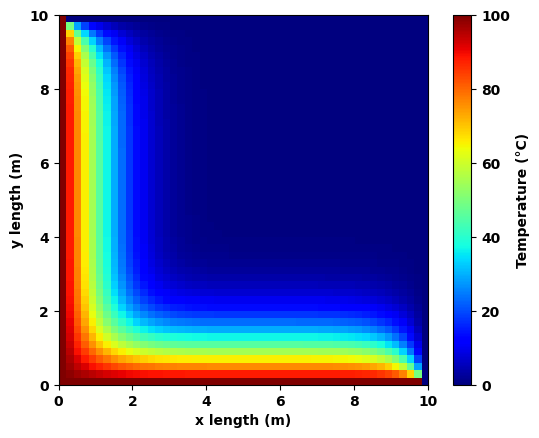

In [5]:
snapshot_id = 110
fig, ax = plt.subplots()
cax = ax.imshow(temp_new[snapshot_id], origin='lower', cmap='jet', extent=[0, Lx, 0, Lz])
fig.colorbar(cax, label="Temperature (°C)")
plt.xlabel(xlabel="x length (m)")
plt.ylabel(ylabel="y length (m)")

def update(frame):
    cax.set_array(temp_new[frame])
    ax.set_title(f"Time step {frame}")
    return [cax]

ani = animation.FuncAnimation(fig, update, frames=len(temp_new), interval=50, blit=False)
plt.show()


In [ ]:
# # Save the animation
# ani.save(r"comgeo-things\figures\heat_conduction.gif", writer="pillow", fps=10)